## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install wandb
import wandb
wandb.login()

In [2]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2020-05-27 15:12:30--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py.5’

losses.py.5         100%[===================>]   5.05K  --.-KB/s    in 0s      

2020-05-27 15:12:31 (52.7 MB/s) - ‘losses.py.5’ saved [5169/5169]



In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import cv2
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)



## Getting the dataset

In [4]:
!git clone https://github.com/thunderInfy/imagenet-5-categories


fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [0]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(1250, 128, 128, 3) (1250,)



(250, 128, 128, 3) (250,)


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(256, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Training the encoder and the projector

In [0]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'


In [0]:
def aug(image):
  x=tf.image.random_brightness(image,max_delta=0)
  x=tf.image.random_contrast(x,lower=0.2, upper=1.8)
  #x = tf.clip_by_value(x, 0, 1)

  return x

Epoch: 0 Loss: 0.224
Epoch: 10 Loss: 0.108
Epoch: 20 Loss: 0.075
Epoch: 30 Loss: 0.042
Epoch: 40 Loss: 0.003
Epoch: 50 Loss: 0.003



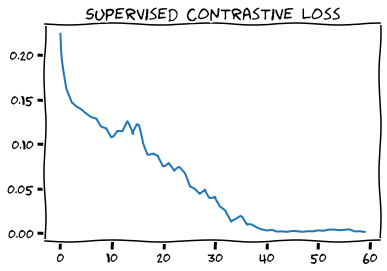

[<tf.Tensor: shape=(), dtype=float32, numpy=0.22391064>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16231322>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14661029>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14145975>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13840057>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13381872>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1302933>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1289336>, <tf.Tensor: shape=(), dtype=float32, numpy=0.120474264>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11863296>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1084701>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11540012>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11502062>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12550323>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11108516>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12200363>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1013246>, <tf.Tensor: shape=(), dtype=float32, numpy=0.08876

In [17]:
import time

#wandb.init(project="scl", entity="authors", id="supervised-contrastive-crctd")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		images=aug(images)
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	#wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
#wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

## Supervised Model

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [0]:
from wandb.keras import WandbCallback

In [0]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [20]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

#wandb.init(project="scl", entity="authors",id='F')


supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[es])

Epoch 1/100
20/20 [==============================] - 5s 267ms/step - loss: 1.3957 - sparse_categorical_accuracy: 0.8984 - val_loss: 1.3428 - val_sparse_categorical_accuracy: 0.7160
Epoch 2/100
20/20 [==============================] - 4s 179ms/step - loss: 0.9814 - sparse_categorical_accuracy: 0.9968 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.7200
Epoch 3/100
20/20 [==============================] - 3s 175ms/step - loss: 0.6768 - sparse_categorical_accuracy: 0.9968 - val_loss: 1.0076 - val_sparse_categorical_accuracy: 0.7200
Epoch 4/100
20/20 [==============================] - 4s 177ms/step - loss: 0.4732 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.9291 - val_sparse_categorical_accuracy: 0.7160
Epoch 5/100
20/20 [==============================] - 4s 178ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.8858 - val_sparse_categorical_accuracy: 0.7160
Epoch 6/100
20/20 [==============================] - 4s 178ms/step - loss: 0.2592 - sparse_cate